In [2]:
import pandas as pd
import numpy as np

# data loading
csv_path = "final_dataset.csv"    
tau = 0.05                         # threshold for unchanged: |ΔV| <= tau


# Load data
df = pd.read_csv(csv_path)

required_cols = [
    "forum_name",
    "thread_id",
    "post_content",
    "Cohort",
    "initial_emotion",
    "initial_prob",
    "final_pred_emotion",
    "final_pred_prob",
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# Valence mapping for Ekman emotions
VALENCE_MAP = {
    "anger":   -1.0,
    "sadness": -1.0,
    "fear":    -1.0,
    "disgust": -1.0,
    "neutral":  0.0,
    "surprise": 0.0,
    "joy":      1.0,
}

#  Normalise label case and map to valence
df["initial_emotion_clean"] = df["initial_emotion"].str.strip().str.lower()
df["final_emotion_clean"]   = df["final_pred_emotion"].str.strip().str.lower()

df["valence_init_label"] = df["initial_emotion_clean"].map(VALENCE_MAP)
df["valence_final_label"] = df["final_emotion_clean"].map(VALENCE_MAP)

#  Ensure probabilities are floats
df["initial_prob"] = pd.to_numeric(df["initial_prob"], errors="coerce")
df["final_pred_prob"] = pd.to_numeric(df["final_pred_prob"], errors="coerce")

# Compute expected valence using label * prob
#    V_init = valence(initial_emotion) * P(initial_emotion)
#    V_final = valence(final_emotion) * P(final_emotion)
df["V_init"] = df["valence_init_label"] * df["initial_prob"]
df["V_final"] = df["valence_final_label"] * df["final_pred_prob"]

#   Compute ΔV
df["delta_V"] = df["V_final"] - df["V_init"]

#  Classify trajectory based on ΔV
def classify_trajectory(delta_v, threshold):
    if pd.isna(delta_v):
        return "unknown"
    if delta_v > threshold:
        return "improved"
    elif delta_v < -threshold:
        return "worsened"
    else:
        return "unchanged"

df["trajectory"] = df["delta_V"].apply(lambda dv: classify_trajectory(dv, tau))

# Summaries
print("Trajectory counts:")
print(df["trajectory"].value_counts(dropna=False))

print("\nMean delta_V by trajectory:")
print(df.groupby("trajectory")["delta_V"].mean())

print("\nSample rows:")
print(
    df[
        [
            "forum_name",
            "thread_id",
            "Cohort",
            "initial_emotion",
            "initial_prob",
            "final_pred_emotion",
            "final_pred_prob",
            "V_init",
            "V_final",
            "delta_V",
            "trajectory",
        ]
    ].head(10)
)

#  Save updated CSV
output_path = "final_dataset_with_trajectory.csv"
df.to_csv(output_path, index=False)
print(f"\nSaved updated dataset with trajectory to: {output_path}")


Trajectory counts:
trajectory
improved     11321
worsened       949
unchanged      493
Name: count, dtype: int64

Mean delta_V by trajectory:
trajectory
improved     1.112668
unchanged    0.002905
worsened    -0.487389
Name: delta_V, dtype: float64

Sample rows:
  forum_name  thread_id Cohort initial_emotion  initial_prob  \
0    anxiety     610659      B            fear      0.341005   
1    anxiety     611578      B            fear      0.625716   
2    anxiety     611573      B         sadness      0.547605   
3    anxiety     611587      B            fear      0.416352   
4    anxiety     180185      B         sadness      0.882927   
5    anxiety     611516      B         sadness      0.729903   
6    anxiety     516409      A             joy      0.900476   
7    anxiety     605332      A             joy      0.868143   
8    anxiety     611391      B            fear      0.443413   
9    anxiety     610948      B             joy      0.459849   

  final_pred_emotion  final_pred

In [3]:
import pandas as pd

# file path
TRAJ_FILE = "final_dataset_with_trajectory.csv"

traj_df = pd.read_csv(TRAJ_FILE)
print("Columns:", traj_df.columns.tolist())
traj_df.head()

Columns: ['forum_name', 'thread_id', 'post_content', 'Cohort', 'initial_emotion', 'initial_prob', 'final_pred_emotion', 'final_pred_prob', 'initial_emotion_clean', 'final_emotion_clean', 'valence_init_label', 'valence_final_label', 'V_init', 'V_final', 'delta_V', 'trajectory']


,forum_name,thread_id,post_content,Cohort,initial_emotion,initial_prob,final_pred_emotion,final_pred_prob,initial_emotion_clean,final_emotion_clean,valence_init_label,valence_final_label,V_init,V_final,delta_V,trajectory
0,anxiety,610659,hi my name is michelle and i have had anxiety ...,B,fear,0.341005,joy,0.928310,fear,joy,-1.0,1.0,-0.341005,0.928310,1.269315,improved
1,anxiety,611578,i ve never written on a forum like this before...,B,fear,0.625716,joy,0.890014,fear,joy,-1.0,1.0,-0.625716,0.890014,1.515730,improved
2,anxiety,611573,i am international student to tasmania in 2021...,B,sadness,0.547605,joy,0.790593,sadness,joy,-1.0,1.0,-0.547605,0.790593,1.338198,improved
3,anxiety,611587,"hello, i struggle with feeling very home sick ...",B,fear,0.416352,joy,0.944687,fear,joy,-1.0,1.0,-0.416352,0.944687,1.361039,improved
4,anxiety,180185,and it was entirely my own fault. i tried cros...,B,sadness,0.882927,joy,0.706641,sadness,joy,-1.0,1.0,-0.882927,0.706641,1.589568,improved


Trajectory counts:
trajectory
improved     11321
unchanged      493
worsened       949
Name: count, dtype: int64


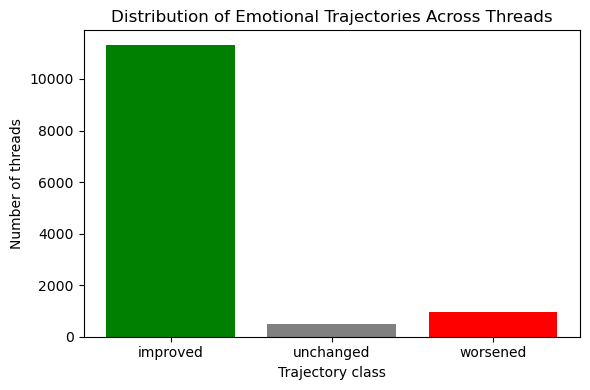

In [4]:
# Emotional trajectory distribution

import matplotlib.pyplot as plt

order = ["improved", "unchanged", "worsened"]
traj_counts = traj_df["trajectory"].value_counts().reindex(order, fill_value=0)

print("Trajectory counts:")
print(traj_counts)

plt.figure(figsize=(6, 4))
plt.bar(traj_counts.index, traj_counts.values, color=["green", "grey", "red"])
plt.xlabel("Trajectory class")
plt.ylabel("Number of threads")
plt.title("Distribution of Emotional Trajectories Across Threads")
plt.tight_layout()
plt.show()

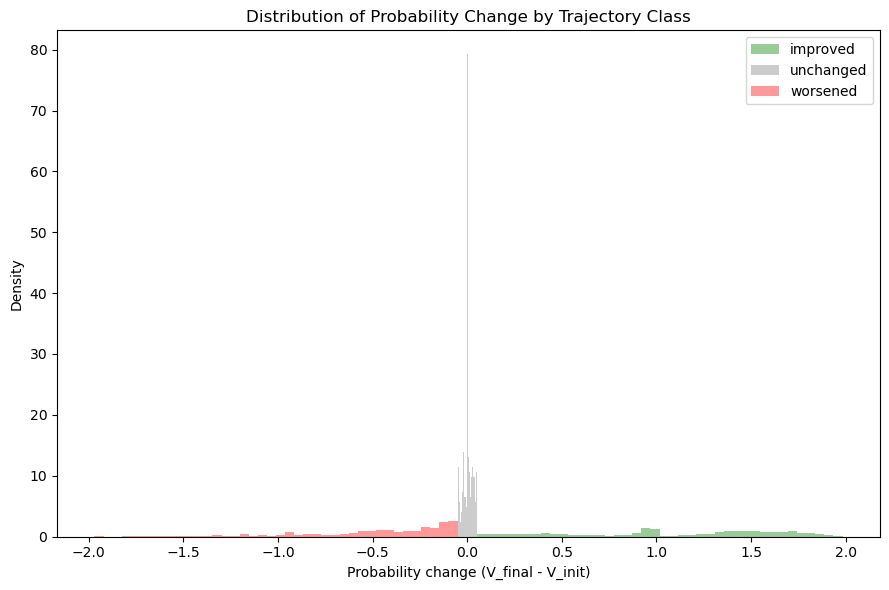

In [6]:
# Probability change distribution per trajectory

plt.figure(figsize=(9,6))

colors = {"improved":"green", "unchanged":"grey", "worsened":"red"}

for traj in order:
    subset = traj_df[traj_df["trajectory"] == traj]["delta_V"]
    plt.hist(
        subset,
        bins=40,
        alpha=0.4,
        label=traj,
        density=True,
        color=colors[traj]
    )

plt.xlabel("Probability change (V_final - V_init)")
plt.ylabel("Density")
plt.title("Distribution of Probability Change by Trajectory Class")
plt.legend()
plt.tight_layout()
plt.show()